# ARIMA Model

First, we'll take a look at the ARIMA model. The ARIMA model is from the same family of models as the VAR model which we have discussed previously, they're from the Autoregression modelling family. ARIMA stands for:\
i) AR - AutoRegressive - forecasts based on the past values in the series called lags,\
ii) I - Integrated - involves differencing the time series to make it stationary,\
iii) MA - Moving Average - forecasts based on the past errors in the series called error lags.

It's similar to the VAR model, however it used for a single time series where we have one observed variable. In our case, this will be the value of the pollution.

## Importing required libraries

In [ ]:
#For data wrangling
import numpy as np
import pandas as pd
#To load the data
import pickle 
#Importing our model
from statsmodels.tsa.arima.model import ARIMA
#For visualisation
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#Assessing performance of the model
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_squared_error
#To see if data is stationary
from statsmodels.tsa.stattools import adfuller

## Load the data

In [21]:
#Training data
with open('../data/train_data.pickle', 'rb') as f:
    train_data = pickle.load(f)

We'll start by taking a quick look at our training data to see what we're getting into.

In [22]:
train_data

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,0.129779,0.352941,0.245902,0.527273,0.333333,0.002290,0.000000,0.000000
2010-01-02 01:00:00,0.148893,0.367647,0.245902,0.527273,0.333333,0.003811,0.000000,0.000000
2010-01-02 02:00:00,0.159960,0.426471,0.229508,0.545455,0.333333,0.005332,0.000000,0.000000
2010-01-02 03:00:00,0.182093,0.485294,0.229508,0.563636,0.333333,0.008391,0.037037,0.000000
2010-01-02 04:00:00,0.138833,0.485294,0.229508,0.563636,0.333333,0.009912,0.074074,0.000000
...,...,...,...,...,...,...,...,...
2014-07-02 07:00:00,0.058350,0.882353,0.655738,0.236364,0.333333,0.003811,0.000000,0.000000
2014-07-02 08:00:00,0.057344,0.882353,0.672131,0.236364,1.000000,0.000752,0.000000,0.027778
2014-07-02 09:00:00,0.052314,0.897059,0.672131,0.236364,0.333333,0.000752,0.000000,0.055556


We only require the pollution column as the ARIMA model only takes one variable as the input and this is the one that is of interest. Going forward we'll isolate this column within our dataset to ensure this is what we're working with.

## Visualising the data

We want to visualise how pollution changes over time and see what the data looks like.

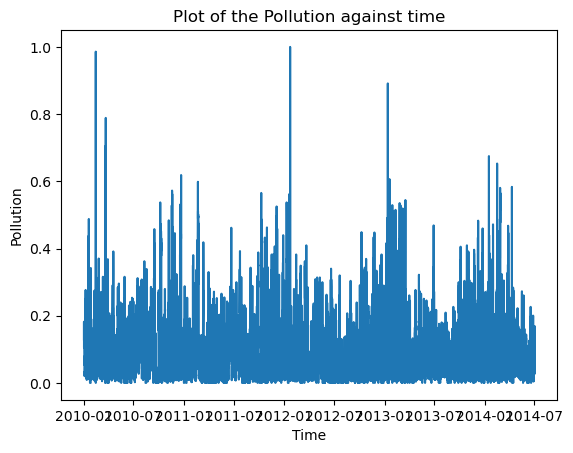

In [23]:
#Isolating pollution variable
variable_of_interest = train_data['pollution']

#Plotting pollution against time
plt.plot(variable_of_interest)
plt.title('Plot of the Pollution against time')
plt.xlabel('Time')
plt.ylabel('Pollution')
plt.show()

We can see a trend of the pollution being pretty cyclical, it's at its peak during the winter months and at its lowest during the summer months, producing a sinusodial looking graph. The reason for this is because cold air in denser than warm air and therefore traps more pollution. But as we can see, there doesn't appear to be too mych variation on a day to day basis and it looks like it varies randomly.

## PACF and ACF

We'll now take a look at the correlation graphs for the pollution variable to aid us in deciding what parameters we want to choose for our model. 

The ACF graph measures how much the time series is correlated to itself at different lags.

The PCF graph measures how much of the correlation between the pollution variable and its previous lags is not explained by the correlation between the previous lag in question and the intermediate lags.

These will be key to help us decide what the AR and MA terms are in our model.

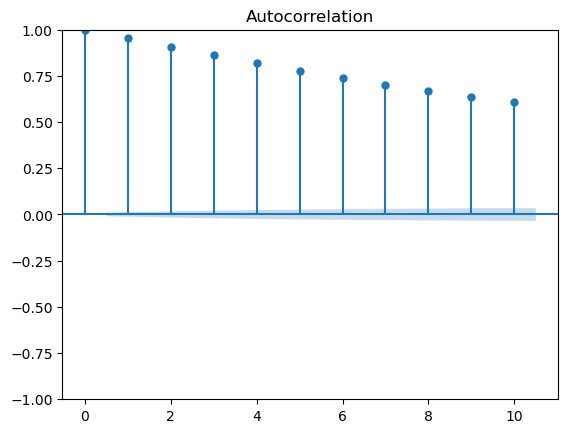

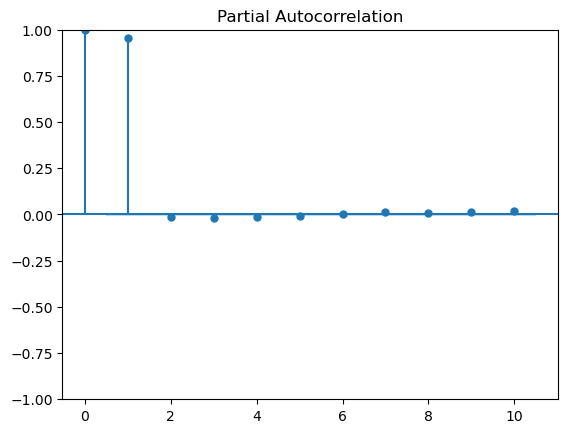

In [24]:
plot_acf(train_data['pollution'].dropna(), lags=10)
plt.show()

plot_pacf(train_data['pollution'].dropna(), lags=10)
plt.show()

As we can see in the ACF graph, the correlation has a gradual decrease as the number of lags increases, showing that more and more lags won't contribute to the performance of the model too much. The PACF graph looks a lot different, after the first lag there is a sharp drop and the other lags have essentially no effect, whilst the first lag has a large impact on the next value. Due to this, we will choose both our AR and MA values to be 1 in our initial models.

The high partial correlation with the first lag and negligible partial correlation with the pther lags may be indicative of the nature of the problem we're dealing with. Since it's air pollution, it's not silly to think that a good prediction for the air pollution in the next hour is simply the air pollution now as it's unlikely to vary too much, resulting in what we see above.

## Augmented Dickey-Fuller Test

We'll now check that the data is stationary using the Augmented Dickey-Fuller test. This is a statistical test. The Null Hypothesis is that the the series is non-stationary, with the Alternate Hypothesis being that it is stationary.

We'll test this at a 5% significance level so if the p-value generated is less than 0.05 than we can reasonably assume that the data is non-stationary.

This is key for determining the value in our model corresponding to the I in ARIMA. If our data is non-stationary we can set this to 0.

In [25]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train_data['pollution'])

adf_statistic = result[0]
p_value = result[1]

print(f"ADF Statistic: {adf_statistic}")
print(f"P-Value: {p_value}")

ADF Statistic: -19.566524660105763
P-Value: 0.0


Since our p-value is very small we can reject the null hypothesis and conclude that our data is stationary, meaning it has constant mean and variance throughout. We can now proceed with our investigation with the diferencing in the ARIMA model equal to 0. This reduces it down to an ARMA model as there is no need for the 'integrated' part.

This aligns with what we saw from the graph of the pollution over time we saw earlier. From just looking at it it was pretty safe to assume that the mean and variance stayed virtually constant throughout, and the ADF test used above has confirmed this for us.

## Creating the validation split

We'll now split our training data into a test and validation set so that we can assess our model later on.

In [26]:
train_size = int(len(train_data) * 0.999)
train_df = train_data[:train_size]
val_df = train_data[train_size:]

In [27]:
#Looking at our training data for pollution
train_df['pollution']

date
2010-01-02 00:00:00    0.129779
2010-01-02 01:00:00    0.148893
2010-01-02 02:00:00    0.159960
2010-01-02 03:00:00    0.182093
2010-01-02 04:00:00    0.138833
                         ...   
2014-06-30 15:00:00    0.074447
2014-06-30 16:00:00    0.072435
2014-06-30 17:00:00    0.051308
2014-06-30 18:00:00    0.054326
2014-06-30 19:00:00    0.040241
Name: pollution, Length: 39380, dtype: float64

We have successively created our splits.

## Fitting our initial model

We'll now fit our model using the values we arrived at earlier using the ACF and PACF graphs, and the ADF test. As a reminder these were 1 and 0.

The model will be trained on the training split we created above with our chosen values for the ARIMA model and then we'll attempt to forecast the next values of the pollution and see how this compares to our validation values.

In [ ]:
#Fitting model
train_df.index.freq = 'h'
model = ARIMA(train_df['pollution'], order=(1, 0, 1))
model = model.fit()
#Summary of our model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              pollution   No. Observations:                39380
Model:                 ARIMA(1, 0, 1)   Log Likelihood               84994.839
Date:                Mon, 25 Nov 2024   AIC                        -169981.678
Time:                        23:55:16   BIC                        -169947.354
Sample:                    01-02-2010   HQIC                       -169970.805
                         - 06-30-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0951      0.004     23.930      0.000       0.087       0.103
ar.L1          0.9529      0.001    972.417      0.000       0.951       0.955
ma.L1          0.0120      0.001     12.328      0.000       0.010       0.014
sigma2         0.0008   1.03e-06    755.570      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          22689067.02
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                       120.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
#Forecasting future values
forecast = model.forecast(steps=len(val_df))
forecast

2014-06-30 20:00:00    0.042633
2014-06-30 21:00:00    0.045104
2014-06-30 22:00:00    0.047459
2014-06-30 23:00:00    0.049702
2014-07-01 00:00:00    0.051840
2014-07-01 01:00:00    0.053877
2014-07-01 02:00:00    0.055818
2014-07-01 03:00:00    0.057668
2014-07-01 04:00:00    0.059430
2014-07-01 05:00:00    0.061110
2014-07-01 06:00:00    0.062710
2014-07-01 07:00:00    0.064235
2014-07-01 08:00:00    0.065687
2014-07-01 09:00:00    0.067072
2014-07-01 10:00:00    0.068391
2014-07-01 11:00:00    0.069648
2014-07-01 12:00:00    0.070846
2014-07-01 13:00:00    0.071987
2014-07-01 14:00:00    0.073074
2014-07-01 15:00:00    0.074110
2014-07-01 16:00:00    0.075098
2014-07-01 17:00:00    0.076039
2014-07-01 18:00:00    0.076935
2014-07-01 19:00:00    0.077789
2014-07-01 20:00:00    0.078603
2014-07-01 21:00:00    0.079379
2014-07-01 22:00:00    0.080118
2014-07-01 23:00:00    0.080822
2014-07-02 00:00:00    0.081493
2014-07-02 01:00:00    0.082132
2014-07-02 02:00:00    0.082741
2014-07-

Below we find what the root mean squared value is for our predictions, a measure of distance between the actual value and what we've forecasted.

In [ ]:
mse = mean_squared_error(val_df['pollution'], forecast)
rmse = np.sqrt(mse)
print(f"RMSE on validation set: {rmse}")

RMSE on validation set: 0.041199377609662406


Although this is small, so is the scale of our data. This is a sign our model hasn't performed as well as we'd like.

Below we'll plot our forecasted values and the validation data on the same graph to see how the ARIMA test has performed.

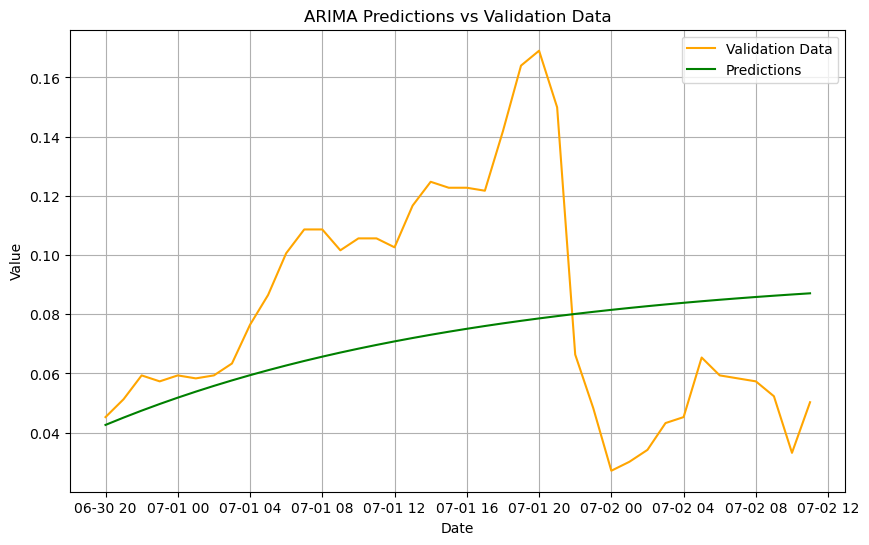

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(val_df['pollution'], label='Validation Data', color='orange')
plt.plot(val_df.index, forecast, label='Predictions', color='green')

plt.title('ARIMA Predictions vs Validation Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)


plt.show()

Obviously that are predictions are tending to a constant value. This is not what we want as it captures none of the variation in the data and merely attempts to find the average. We'll attempt to remedy this with a change in paramters.

## Finding better parameters

We'll run auto_arima which uses will find the optimal parameters for our model. We'll then fit this supposedly improved model and use it to forecast the future pollution levels, again plotting a graph with the validation data and our forecasts to see how it's performed.

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-169506.387, Time=2.88 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-47067.814, Time=2.59 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-169508.988, Time=2.98 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-90386.404, Time=5.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-169506.991, Time=3.24 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-169506.990, Time=2.44 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-169505.334, Time=14.44 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-169978.479, Time=4.56 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-75153.464, Time=6.45 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-169981.913, Time=7.50 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-169998.101, Time=6.19 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-170002.751, Time=5.70 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-170002.352, Time=11.27 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-169982.974, Time=8

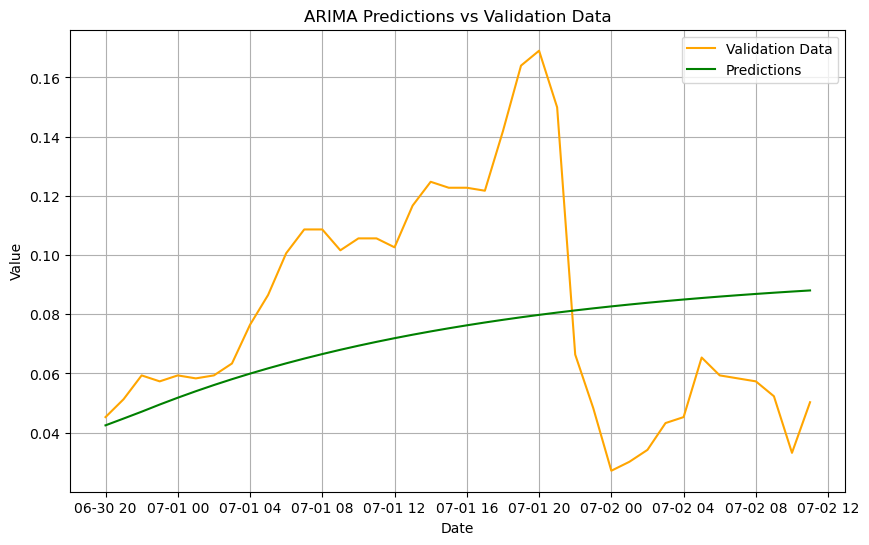

In [44]:
from pmdarima import auto_arima

#Fit the best ARIMA model
auto_model = auto_arima(train_df['pollution'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)

#Forecast for the next len(val_df) steps
forecast_auto = auto_model.predict(n_periods=len(val_df))

#Print forecasted predictions
print(forecast_auto)


#Plot our predictions and validation set
plt.figure(figsize=(10, 6))
plt.plot(val_df['pollution'], label='Validation Data', color='orange')
plt.plot(val_df.index, forecast_auto, label='Predictions', color='green')

plt.title('ARIMA Predictions vs Validation Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

This looks just the same as what we had previously with our predictions appearing to be tending to a constant value, implying that it's not a problem with the parameters but more a fundamental issue with the use of the ARIMA model in this context. We can see below that with a larger validation set that it does indeed stay constant after the first few steps.

In [ ]:
#Creating a training and validation set with a 90/10 split
train_size1 = int(len(train_data) * 0.9)
train_df1 = train_data[:train_size1]
val_df1 = train_data[train_size1:]

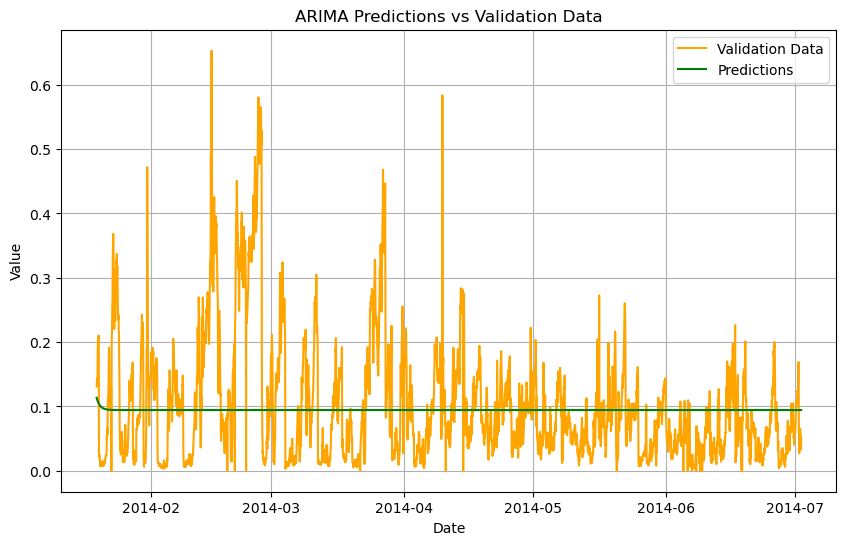

In [ ]:
#Fitting model
train_df1.index.freq = 'h'
model = ARIMA(train_df1['pollution'], order=(4, 0, 0))
arima_model = model.fit()

#Forecasting for future
forecast1 = arima_model.forecast(steps=len(val_df1))

#Plotting grpah
plt.figure(figsize=(10, 6))
plt.plot(val_df1["pollution"], label='Validation Data', color='orange')
plt.plot(val_df1.index, forecast1, label='Predictions', color='green')

plt.title('ARIMA Predictions vs Validation Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

This suggests that for our data that the ARIMA model simply isn't appropriate. There's too much data and as there's no discernible pattern on small scales the ARIMA model just predicts a constant value for the whole thing in order to minimise the error.

## Conclusions

The above makes it an inappropraite model for the task at hand. Even on a relatively small amount of data it gives us nothing in the way of predicting pollution levels and this issue would only continue as the amount of data is scaled up. Furthermore, the 'optimal' model we arrived at using auto_arima takes a hefty amount of time to run, a problem that will be further exarcebated if this was to be used for a big data problem as a large amount of time would be required for it to process the increased amount of data.

All in all, we don't believe that the ARIMA gives us much in the way of being a useful model, nor being appropriate for use as a baseline going forward due to its poor performance. 

## References

ARIMA - https://www.datacamp.com/tutorial/arima

Choosing AR and MA values - https://people.duke.edu/~rnau/411arim3.htm#:~:text=You%20are%20already%20familiar%20with,series%20and%20lags%20of%20itself. 

Augmented Dickey-Fuller - https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/#How_to_Check_Stationarity? 

Auto ARIMA - https://www.analyticsvidhya.com/blog/2018/08/auto-arima-time-series-modeling-python-r/#h-what-is-auto-arima

AI was used for parts of the code.

